## Algorytmy macierzowe

**Maciej Skoczeń**, **Kacper Kafara**

grupa wtorek (A) 17:50

## Mnożenie macierzy IGA i FEM

In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import scipy.sparse
import time
import os

### Konwersja macierzy $n x n$ wygenerowanej w Octave na macierz numpy $nq x nq$.    
Wynikowa macierz, to macierz wygenerowana w Octave powtórzona q razy w poziomie i pionie.

In [2]:
def input_matrix(octave_matrix, n, m, q=1):
    result = np.zeros((n*q, m*q), dtype=np.double)
    
    for elem in octave_matrix:
        m = re.match(r"\s*\((\d+),\s*(\d+)\)\s*->\s*(\d+\.\d+)\s*", elem)
        if m is not None:
            x, y, value = m.groups()
        elif len(elem) > 0:
            coord, value = elem.strip().split(' -> ')
            value = float(value)
            x, y = coord.split(',')
            x, y = x[1:], y.strip()[:-1]
        else:
            continue
        
        for i in range(q):
            for j in range(q):
                result[i*n + int(x) - 1, j*n + int(y) - 1] = float(value)
        
    return result

In [3]:
def load_octave_matrix(filename):
    with open(filename, "r") as file:
        return file.readlines()

In [4]:
data_dir = "../output"

def resolve_path(matrix_type, width, height = None):
    if height is None: height = width
    path = f"{data_dir}/{matrix_type}-{width}x{height}.txt"
    if os.path.isfile(path): return path
    else: raise FileNotFoundError(f"Matrix file {path} not found")

resolve_matrix = lambda matrix_type, n, m, q = 1: input_matrix(
    load_octave_matrix(resolve_path(matrix_type, n, m)), n, m, q
)

In [5]:
def timeit(times = 1, loops = 2):
    def timed_func(func):
        def wrapper(*args):
            tries_time = 0
            for n_try in range(times):
                loops_time = 0
                for loop in range(loops):
                    t_start = time.time()
                    func(*args)
                    loops_time += time.time() - t_start
                tries_time += loops_time / loops
            return tries_time / times
        return wrapper
    return timed_func

### Sześć algorytmów mnożenia macierzy w zależności od kolejności pętli i, j, p.    
A - macierz wejściowa $n x m$    
B - macierz wejściowa $m x k$   
C - macierz wynikowa $n x k$

Najbardziej zagnieżdzone pętle zostały zamienione na funkcje, co przyspieszyło znacząco czasy mnożenia. Zamiany kolejnych pętel nie powodowały już zmian.

In [6]:
def dot_product(vect1, vect2, k):
    result = 0
    for p in range(k):
        result += vect1[p]*vect2[p]
    return result
    
def mul_and_add(val, vect, result, m):
    for j in range(m):
        result[j] += val*vect[j]

In [7]:
def matrix_mul_ijp(A, B, C, n, m, k):
    for i in range(n):
        for j in range(m):
            C[i,j] = dot_product(A[i, 0:k], B[0:k, j], k)
                    
def matrix_mul_ipj(A, B, C, n, m, k):
    for i in range(n):
        for p in range(k):
            mul_and_add(A[i, p], B[p,0:n], C[i, 0:n], m)

def matrix_mul_jip(A, B, C, n, m, k):
    for j in range(m):
        for i in range(n):
            C[i,j] = dot_product(A[i, 0:k], B[0:k, j], k)

def matrix_mul_jpi(A, B, C, n, m, k):
    for j in range(m):
        for p in range(k):
            mul_and_add(B[p, j], A[0:m, p], C[0:m, j], n)

def matrix_mul_pij(A, B, C, n, m, k):
    for p in range(k):
        for i in range(n):
            mul_and_add(A[i, p], B[p,0:n], C[i, 0:n], m)

def matrix_mul_pji(A, B, C, n, m, k):
    for p in range(k):
        for j in range(m):
            mul_and_add(B[p, j], A[0:m, p], C[0:m, j], n)

mmul = {
    "warmuprun": matrix_mul_ijp,
    "ijp": matrix_mul_ijp,
    "ipj": matrix_mul_ipj,
    "jip": matrix_mul_jip,
    "jpi": matrix_mul_jpi,
    "pij": matrix_mul_pij,
    "pji": matrix_mul_pji
}

### Macierze wejściowe

In [8]:
SIZE = 256
n = SIZE   # liczba wierszy macierzy A
m = SIZE   # liczba kolumn macierzy A / liczba wierszy macierzy B
k = SIZE   # liczba kolumn macierzy B
q = 3      # czynnik skalujący macierze
N_n = n * q
N_m = m * q
N_k = k * q

In [9]:
A = resolve_matrix("iga", n, m, q)
B = resolve_matrix("fem", m, k, q)
print("Wymiary macierzy A:", A.shape)
print("Wymiary macierzy B:", B.shape)

Wymiary macierzy A: (768, 768)
Wymiary macierzy B: (768, 768)


### Sprawdzanie najszybszego algorytmu

In [10]:
stats = {}

min_loop_time = None
min_mul_type = "ijp"
mmul_optimal = mmul[min_mul_type]

for mul_type, mul_fun in mmul.items():
    print(f"{mul_type}:")
    C = np.zeros((N_n, N_k))
    loop_time = %timeit -n 1 -r 1 -o mul_fun(A, B, C, N_n, N_m, N_k)
    if mul_type == "warmuprun": continue
    stats[mul_type] = loop_time.average
    if min_loop_time is None or min_loop_time > loop_time.average:
        min_loop_time = loop_time.average
        min_mul_type = mul_type
        mmul_optimal = mul_fun

print(f"\nNajszybsza konfiguracja: {min_mul_type}")

warmuprun:
2min 26s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
ijp:
2min 29s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
ipj:
2min 57s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
jip:
2min 24s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
jpi:
3min 7s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
pij:
2min 55s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
pji:
2min 59s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Najszybsza konfiguracja: jip


In [11]:
from IPython.display import Markdown as md
table = """
| Kolejność pętli | Czas [s] |
|:---------------:|:--------:|
"""
for loop_order, loop_time in stats.items():
    table += f"|{loop_order}|{loop_time:>.6}|\n"

md(table)


| Kolejność pętli | Czas [s] |
|:---------------:|:--------:|
|ijp|149.507|
|ipj|177.24|
|jip|144.26|
|jpi|187.086|
|pij|175.781|
|pji|179.579|


Zgodnie z powyższą tabelką i kilkoma uruchomieniami algorytmów, najszybsze mnożenie uzyskaliśmy stosując kolejność pętli jip.

### Arbitralny wybór optymalnego algorytmu 

Jeżeli ma zostać wykorzystany algorytm wyznaczony obliczeniowo (w komórce powyżej), nie wykonywać komórki poniżej.

In [12]:
mmul_optimal = mmul["ijp"]

### Sprawdzanie niezerowych miejsc macierzy A, B i C
Poniżej wykresy dla macierzy wejściowych odpowiednio A, B i macierzy wynikowej C.

In [13]:
C = np.zeros((N_n, N_k))
%timeit -n 1 -r 1 mmul_optimal(A, B, C, N_n, N_m, N_k)

2min 31s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


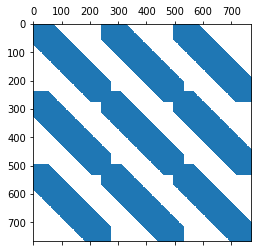

In [14]:
plt.spy(scipy.sparse.csr_matrix(A))
plt.show()

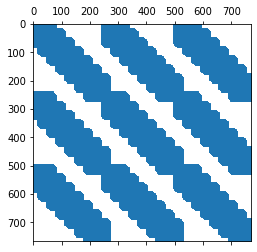

In [15]:
plt.spy(scipy.sparse.csr_matrix(B))
plt.show()

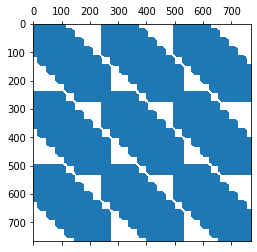

In [16]:
plt.spy(scipy.sparse.csr_matrix(C))
plt.show()

### Mnożenie blokowe macierzy optymalnym algorytmem przyjmując różne wielkości bloków.

Gdzie matrix_mul_fun to jedna z wybranych funkcji (optymalna) mnożenia macierzy zaimplementowanych wyżej.

In [17]:
def matrix_block_mul(A, B, C, n, m, k, block_size, matrix_mul_fun):
    for j in range(0, m, block_size):
        j_block = min(m - j, block_size)
        for i in range(0, n, block_size):
            i_block = min(n - i, block_size)
            for p in range(0, k, block_size):
                p_block = min(k - p, block_size)
                matrix_mul_fun(A[i:i + i_block, p:p + p_block], 
                               B[p:p + p_block, j:j + j_block], 
                               C[i:i + i_block, j:j + j_block], 
                               i_block, j_block, p_block)

Obliczenia dla rozmiaru bloku 4  282.25
Obliczenia dla rozmiaru bloku 8  206.16
Obliczenia dla rozmiaru bloku 16  172.01
Obliczenia dla rozmiaru bloku 32  155.01
Obliczenia dla rozmiaru bloku 64  148.61
Obliczenia dla rozmiaru bloku 128  146.9
Obliczenia dla rozmiaru bloku 192  150.0
Obliczenia dla rozmiaru bloku 256  147.27
Obliczenia dla rozmiaru bloku 320  146.74
Obliczenia dla rozmiaru bloku 384  140.14
Obliczenia dla rozmiaru bloku 448  138.15
Obliczenia dla rozmiaru bloku 512  138.32


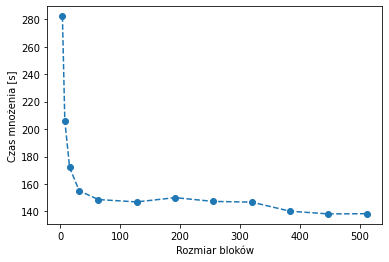

In [18]:
from math import log
block_sizes = [2**i for i in range(2, int(log(N_n * q, 2))) if 2**i <= N_n]
block_sizes.extend([128 + 64, 256 + 64, 256 + 2 * 64, 256 + 3 * 64])
block_sizes.sort()

mul_time = []
runs = 1

for block_size in block_sizes:
    print("Obliczenia dla rozmiaru bloku", block_size, end='  ')
    C = np.zeros((N_n, N_k))
    t0 = time.time()
    for j in range(runs):
        matrix_block_mul(A, B, C, N_n, N_m, N_k, block_size, mmul_optimal)
    run_time = time.time() - t0 / runs
    mul_time.append(run_time)
    print(f"{run_time:.5}")
    
plt.plot(block_sizes, mul_time, linestyle='--')
plt.scatter(block_sizes, mul_time)
plt.xlabel("Rozmiar bloków")
plt.ylabel("Czas mnożenia [s]")
plt.show()

Optymalną wielkością bloku dla naszych macierzy jest 448 x 448.

### Liczba operacji zmiennoprzecinkowych w standardowym algorytmie mnożenia macierzy

W każdej iteracji w najbardziej wewnętrznej pętli wykonujemy jedno dodawanie i jedno mnożenie -> $2m$ operacji zmiennoprzecinkowych. Wchodzimy w tę pętlę dokładnie $n * k$ razy (dwie zewnętrzne pętle). Sumarycznie wychodzi $2nmk$ operacji zmiennoprzecinkowych. 

### Liczba operacji zmiennoprzecinkowych w algorytmie blokowego mnożenia macierzy

Niech $A = [a_{ij}]_{n x m} = [A_{ij}]_{NxM}$, $B = [b_{ij}]_{mxk} = [B_{ij}]_{MxK}$, $C = AB = [c_{ij}]_{nxk} = [C_{ij}]_{NxK}$, gdzie przez $A_{ij}$, $B_{ij}$, $C_{ij}$ rozumiemy odpowiednie macierze blokowe rozmiarów, odpowiednio $\frac{n}{N}x\frac{m}{M}$, $\frac{m}{M}x\frac{k}{K}$, $\frac{n}{N}x\frac{k}{K}$.

Obliczenie $C_{ij}$ wymaga $M$ mnożeń macierzy. Każde mnożenie macierzy, korzystając z poprzedniego rezultatu, kosztuje $2\frac{nmk}{NMK}$ operacji zmiennoprzecinkowych. Otrzymamy zatem $N * K * M * 2 * \frac{nmk}{NMK} = 2nmk$ operacji. Do tego potrzebujemy doliczyć jeszcze dodawania/odejmowania wykonywane przy wywołaniu funkcji $min$ oraz przy obliczaniu zakresu bloków (*) -> $M + NM + 7NMK$. W naszym szczególnym przypadku $n = m = k$, $N = M = K$ -> $N + N^2 + N^3$ flop.

Zatem w przypadku naszych macierzy, mnożenie ich będzie wymagać następującej liczby operacji zmiennoprzecinkowych (bez uwzględnienia (*)):



In [19]:
n, m = A.shape
_, k = B.shape

print(2 * n * m * k)

905969664


Jeżeli natomiast uwzględnimy (*) i przyjmiemy $N = 2$ otrzymamy:

In [20]:
print (2 * n * m * k + 2 + 4 + 8)

905969678


Widzimy też, że przy małych blokach (a więc dużych $N$ liczba operacji gwałtownie ($x^3$) wzrośnie -- co możemy obserwować na wykresie.